# Aging Aware with Model Variation
Previously, we optimize the following functional:
$$ \min_\theta \, \int_{t=0}^{1} \; L(\theta(t)) \, {\rm d}t. $$
The optimum is for a specific aging model $\omega$, i.e., we minimized the 
$$ \min_\theta \, \int_{t=0}^{1} \; L(\theta(t,\omega)) \, {\rm d}t. $$
However, we dont know how will the resistance decay, i.e., we should also minimize the loss function w.r.t. aging models with different parameters. That means we need to optimized
$$ \min_\theta \, \int_{\omega}\int_{t=0}^{1} \; L(\theta(t,\omega)) \, {\rm d}t\, p(\omega){\rm d}\omega. $$
The Mento Carlo Approximation is then
$$
\min_{\theta_{\rm init}} \frac{1}{\Omega}\frac{1}{K}\sum_{\omega\in\mathfrak{M}}\sum_{k\in \mathfrak{K} } L \left(\theta[k, \omega]\right),
$$
where $\mathfrak{M}$ is the set of $\Omega$ elements following the distribution $p(\omega)$. $p(\omega)$ is the distributions of parameters of the aging model. We have already obtained these distributions as we modeled the aging decay.

That means we should optimize this problem by
$$
\begin{align}
\theta_{\rm init}&:=\theta_{\rm init} - \alpha\cdot\nabla_{\theta_{\rm init}}\left(\frac{1}{\Omega}\frac{1}{K}\sum_{\omega\in\mathfrak{M}}\sum_{k\in \mathfrak{K} } L \left(\theta[k, \omega]\right)\right)\\
&=\theta_{\rm init} - \frac{\alpha}{\Omega K}\cdot\nabla_{\theta_{\rm init}}\left(\sum_{\omega\in\mathfrak{M}}\sum_{k\in \mathfrak{K} } L \left(\theta[k, \omega]\right)\right)\\
&=\theta_{\rm init} - \frac{\alpha}{\Omega K}\left(\sum_{\omega\in\mathfrak{M}}\sum_{k\in \mathfrak{K} }\nabla_{\theta_{\rm init}} L \left(\theta[k, \omega]\right)\right)
\end{align}
$$

# Get aging model

In [1]:
import importlib
from torch.autograd import Variable
import torch
import pickle
import pNN_aging_aware as pnn
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import training
sys.path.append(os.path.join(os.getcwd(), 'Aging_Model'))

with open(os.path.join(os.getcwd(), 'Aging_Model', 'exp_aging_model.p'), 'rb') as f:
    age_generator = pickle.load(f)

# Prepare data

## Load data

In [2]:
datapath = os.path.join(os.getcwd(), 'Datasets', 'PMLC',
                        'data_processed', 'Dataset_Pendigits.p')
with open(datapath, 'rb') as f:
    dataset = pickle.load(f)
X = dataset['X'].float()
y = dataset['y']
M, N_features, N_class = X.shape[0], X.shape[1], torch.max(
    torch.unique(y)).item()+1
X.shape, y.shape, M, N_features, N_class

(torch.Size([10992, 16]), torch.Size([10992]), 10992, 16, 10)

## data preprocessing

In [3]:
# normalization
X = X / (torch.max(X, axis=0)[0] - torch.min(X, axis=0)[0])
X = X - torch.min(X, axis=0)[0]
torch.min(X), torch.max(X)

(tensor(0.), tensor(1.))

In [4]:
X[:10, :9]

tensor([[0.4700, 1.0000, 0.2700, 0.8100, 0.5700, 0.3700, 0.2600, 0.0000, 0.0000],
        [0.0000, 0.8900, 0.2700, 1.0000, 0.4200, 0.7500, 0.2900, 0.4500, 0.1500],
        [0.0000, 0.5700, 0.3100, 0.6800, 0.7200, 0.9000, 1.0000, 1.0000, 0.7600],
        [0.0000, 1.0000, 0.0700, 0.9200, 0.0500, 0.6800, 0.1900, 0.4500, 0.8600],
        [0.0000, 0.6700, 0.4900, 0.8300, 1.0000, 1.0000, 0.8100, 0.8000, 0.6000],
        [1.0000, 1.0000, 0.8800, 0.9900, 0.4900, 0.7400, 0.1700, 0.4700, 0.0000],
        [0.0000, 1.0000, 0.0300, 0.7200, 0.2600, 0.3500, 0.8500, 0.3500, 1.0000],
        [0.0000, 0.3900, 0.0200, 0.6200, 0.1100, 0.0500, 0.6300, 0.0000, 1.0000],
        [0.1300, 0.8900, 0.1200, 0.5000, 0.7200, 0.3800, 0.5600, 0.0000, 0.0400],
        [0.5700, 1.0000, 0.2200, 0.7200, 0.0000, 0.3100, 0.2500, 0.0000, 0.7500]])

In [5]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split

# generate tensordataset
dataset = TensorDataset(X, y)

# split
train_rate = 0.6
test_rate = 0.2
M_train = int(M*train_rate)
M_test = int(M*test_rate)
train_data, rest_data = random_split(dataset, [M_train, M-M_train], generator=torch.Generator().manual_seed(19950102))
test_data, valid_data = random_split(rest_data, [M_test, M-M_train-M_test], generator=torch.Generator().manual_seed(19950102))
len(train_data), len(test_data), len(valid_data)

(6595, 2198, 2199)

In [6]:
# batch
train_loader = DataLoader(train_data, batch_size=len(train_data))
test_loader = DataLoader(test_data, batch_size=len(test_data))
valid_loader = DataLoader(valid_data, batch_size=len(valid_data))

# Hyperparameter

In [7]:
N_Hidden = 8
m = 0.3
T = 0.1
K = 5  # number of time sampling
M = 40  # number of model sampling
K_test = 5
M_test = 10

# Normal NN
## Training

In [8]:
NN = torch.nn.Sequential(torch.nn.Linear(N_features, N_Hidden), torch.nn.Tanh(),
                         torch.nn.Linear(N_Hidden, N_Hidden), torch.nn.Tanh(),
                         torch.nn.Linear(N_Hidden, N_Hidden), torch.nn.Tanh(),
                         torch.nn.Linear(N_Hidden, N_class), torch.nn.Tanh())


def weights_init(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)


NN.apply(weights_init)

optimizer_NN = torch.optim.Adam(NN.parameters(), lr=0.01)
celoss = torch.nn.CrossEntropyLoss()
NN

Sequential(
  (0): Linear(in_features=16, out_features=8, bias=True)
  (1): Tanh()
  (2): Linear(in_features=8, out_features=8, bias=True)
  (3): Tanh()
  (4): Linear(in_features=8, out_features=8, bias=True)
  (5): Tanh()
  (6): Linear(in_features=8, out_features=10, bias=True)
  (7): Tanh()
)

In [9]:
import copy
train_loss_NN, test_loss_NN, parameter_NN = training.train_normal_nn(NN,
                                                                     train_loader,
                                                                     test_loader,
                                                                     optimizer=optimizer_NN,
                                                                     lossfunction=celoss,
                                                                     Epoch=5000)

  0%|          | 0/5000 [00:00<?, ?it/s]

| Epoch:     0 | Accuracy: 0.07052 | Loss: 2.262285709 |
| Epoch:    10 | Accuracy: 0.27343 | Loss: 1.959961772 |
| Epoch:    20 | Accuracy: 0.29754 | Loss: 1.797744751 |
| Epoch:    30 | Accuracy: 0.48635 | Loss: 1.677176952 |
| Epoch:    40 | Accuracy: 0.53048 | Loss: 1.586165190 |
| Epoch:    50 | Accuracy: 0.54140 | Loss: 1.509919286 |
| Epoch:    60 | Accuracy: 0.56369 | Loss: 1.444025159 |
| Epoch:    70 | Accuracy: 0.59827 | Loss: 1.388017893 |
| Epoch:    80 | Accuracy: 0.64923 | Loss: 1.330243349 |
| Epoch:    90 | Accuracy: 0.68517 | Loss: 1.271730304 |
| Epoch:   100 | Accuracy: 0.64695 | Loss: 1.214215994 |
| Epoch:   110 | Accuracy: 0.65651 | Loss: 1.165692449 |
| Epoch:   120 | Accuracy: 0.67516 | Loss: 1.128716230 |
| Epoch:   130 | Accuracy: 0.68289 | Loss: 1.099365354 |
| Epoch:   140 | Accuracy: 0.69290 | Loss: 1.073408604 |
| Epoch:   150 | Accuracy: 0.69927 | Loss: 1.053784728 |
| Epoch:   160 | Accuracy: 0.70746 | Loss: 1.038131952 |
| Epoch:   170 | Accuracy: 0.73

(2985, tensor(0.8277))

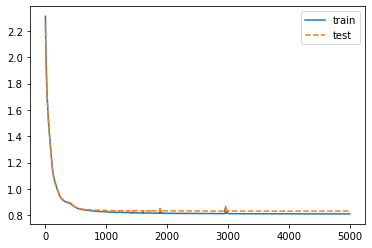

In [10]:
plt.plot(train_loss_NN, '-', label='train')
plt.plot(test_loss_NN, '--', label='test')
plt.legend()
best = np.argmin(test_loss_NN)
best, test_loss_NN[best]

## save model

In [11]:
torch.save(NN, f'./pendigitresult/NN_8_8.pkl')

## load model

In [12]:
NN = torch.load(f'./pendigitresult/NN_8_8.pkl')

## evalutation

In [13]:
for x_valid, y_valid in valid_loader:
    prediction_valid = NN(x_valid)
    p = torch.argmax(prediction_valid, 1)
    pred_y = p.data.numpy().squeeze()
    acc_valid = sum(pred_y == y_valid.numpy()) / y_valid.shape[0]
print(acc_valid)

0.9768076398362893


# PNN
## Training

In [14]:
PNN = torch.nn.Sequential(pnn.PNNLayer(N_features, N_Hidden, age_generator),
                          pnn.PNNLayer(N_Hidden, N_Hidden, age_generator),
                          pnn.PNNLayer(N_Hidden, N_Hidden, age_generator),
                          pnn.PNNLayer(N_Hidden, N_class, age_generator))
optimizer_PNN = torch.optim.Adam(PNN.parameters(), lr=0.01)
PNN

Sequential(
  (0): PNNLayer()
  (1): PNNLayer()
  (2): PNNLayer()
  (3): PNNLayer()
)

In [15]:
train_loss_PNN, test_loss_PNN, parameter_PNN = training.train_normal_pnn(
    PNN, train_loader, test_loader, m, T, optimizer_PNN, pnn.LossFunction, 15000)

  0%|          | 0/15000 [00:00<?, ?it/s]

/pfs/data5/home/kit/tm/px3192/Aging-aware-training/pNN_aging_aware.py:50: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  aging_decay = torch.tensor([m([self.t]) for m in self.model])


| Epoch:     0 | Accuracy: 0.08963 | Loss: 1.392627725 |
| Epoch:    10 | Accuracy: 0.08963 | Loss: 1.384762265 |
| Epoch:    20 | Accuracy: 0.08963 | Loss: 1.344453288 |
| Epoch:    30 | Accuracy: 0.08963 | Loss: 1.122645925 |
| Epoch:    40 | Accuracy: 0.05096 | Loss: 0.797880397 |
| Epoch:    50 | Accuracy: 0.14240 | Loss: 0.739728180 |
| Epoch:    60 | Accuracy: 0.15787 | Loss: 0.713828922 |
| Epoch:    70 | Accuracy: 0.30664 | Loss: 0.706174754 |
| Epoch:    80 | Accuracy: 0.33258 | Loss: 0.703536405 |
| Epoch:    90 | Accuracy: 0.39217 | Loss: 0.701089608 |
| Epoch:   100 | Accuracy: 0.44449 | Loss: 0.699764627 |
| Epoch:   110 | Accuracy: 0.46133 | Loss: 0.698736197 |
| Epoch:   120 | Accuracy: 0.49682 | Loss: 0.697841133 |
| Epoch:   130 | Accuracy: 0.55460 | Loss: 0.696680364 |
| Epoch:   140 | Accuracy: 0.48317 | Loss: 0.695451844 |
| Epoch:   150 | Accuracy: 0.52957 | Loss: 0.693039861 |
| Epoch:   160 | Accuracy: 0.53640 | Loss: 0.689301876 |
| Epoch:   170 | Accuracy: 0.55

(7318, tensor(0.1001, dtype=torch.float64))

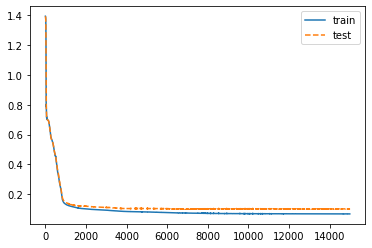

In [16]:
plt.plot(train_loss_PNN, '-', label='train')
plt.plot(test_loss_PNN, '--', label='test')
plt.legend()
best = np.argmin(test_loss_PNN)
PNN.load_state_dict(parameter_PNN)
best, test_loss_PNN[best]

## save PNN

In [17]:
torch.save(PNN, f'./pendigitresult/PNN_8_8.pkl')

## load PNN

In [18]:
PNN = torch.load(f'./pendigitresult/PNN_8_8.pkl')

## Functions for setting times and models

In [19]:
import PNN_Setting as ps
# ps.makemodel
# ps.settime
# ps.zerogradient

Usage of functions: 

`pnn.apply(lambda z: settime(z, time))`

`pnn.apply(makemodel)`

`pnn.apply(zerogradient)`

## evaluation

In [20]:
import evaluation
from tqdm.notebook import tqdm

test_time = np.linspace(0, 1, 50)
PNN_acc = []
PNN_maa = []

for omega in tqdm(range(500)):
    PNN.apply(ps.makemodel)
    for test_t in test_time:
        PNN.apply(lambda z: ps.settime(z, test_t))
        for x_valid, y_valid in valid_loader:
            PNN_acc.append(evaluation.basic(PNN, x_valid, y_valid))
            PNN_maa.append(evaluation.maa(PNN, x_valid, y_valid))
    if omega % 10 == 0:
        print(f'evaluating on the {omega}-th model.')

evaluating on the 0-th model.
evaluating on the 10-th model.
evaluating on the 20-th model.
evaluating on the 30-th model.
evaluating on the 40-th model.
evaluating on the 50-th model.
evaluating on the 60-th model.
evaluating on the 70-th model.
evaluating on the 80-th model.
evaluating on the 90-th model.
evaluating on the 100-th model.
evaluating on the 110-th model.
evaluating on the 120-th model.
evaluating on the 130-th model.
evaluating on the 140-th model.
evaluating on the 150-th model.
evaluating on the 160-th model.
evaluating on the 170-th model.
evaluating on the 180-th model.
evaluating on the 190-th model.
evaluating on the 200-th model.
evaluating on the 210-th model.
evaluating on the 220-th model.
evaluating on the 230-th model.
evaluating on the 240-th model.
evaluating on the 250-th model.
evaluating on the 260-th model.
evaluating on the 270-th model.
evaluating on the 280-th model.
evaluating on the 290-th model.
evaluating on the 300-th model.
evaluating on the 3

In [22]:
PNN_acc = np.array(PNN_acc).reshape([500, 50])
mean_PNN_acc = np.mean(PNN_acc, axis=0).flatten()
std_PNN_acc = np.std(PNN_acc, axis=0).flatten()

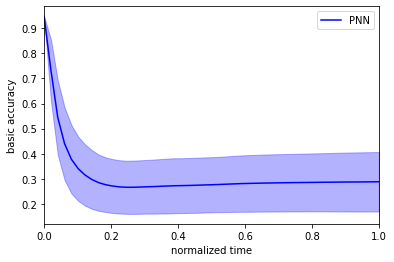

In [23]:
plt.fill_between(test_time, mean_PNN_acc-std_PNN_acc, mean_PNN_acc+std_PNN_acc, alpha=0.3, color='blue');
plt.plot(test_time, mean_PNN_acc, label='PNN', color='blue');
plt.xlabel('normalized time');
plt.ylabel('basic accuracy');
plt.xlim([0, 1]);
plt.legend();

# Aging Aware PNN
## Training

In [8]:
AAPNN = torch.nn.Sequential(pnn.PNNLayer(N_features, N_Hidden, age_generator),
                            pnn.PNNLayer(N_Hidden, N_Hidden, age_generator),
                            pnn.PNNLayer(N_Hidden, N_Hidden, age_generator),
                            pnn.PNNLayer(N_Hidden, N_class, age_generator))

optimizer_AAPNN = torch.optim.Adam(AAPNN.parameters(), lr=0.01)
AAPNN

Sequential(
  (0): PNNLayer()
  (1): PNNLayer()
  (2): PNNLayer()
  (3): PNNLayer()
)

### Functions for generating parallel AAPNNs

In [25]:
# ps.MakeParallelPNNs
# ps.MakeParallelModels

Usage:

`Parallel_PNNs = ps.MakeParallelPNNs(pnn, M, K)`, generating different models & different time stamps

`Parallel_PNNs = ps.MakeParallelPNNs(pnn, M)`, generating only different models

### Joblib

In [27]:
from joblib import Parallel, delayed


def half(k):
    print(k)
    return k/2


r = Parallel(n_jobs=5)(delayed(half)(i) for i in range(10))
r

[0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5]

# Load temp parameter when corrupt

In [9]:
with open('./temp/parameter_AAPNN.p', 'rb') as f:
    parameter_AAPNN = pickle.load(f)
AAPNN.load_state_dict(parameter_AAPNN);

## Parallel Training

In [ ]:
importlib.reload(training)
test_loss_AAPNN, parameter_AAPNN = training.ParallelTrainingAAPNN(AAPNN,
                                                                  train_loader, test_loader,
                                                                  optimizer_AAPNN,
                                                                  pnn.LossFunction, m, T,
                                                                  M, K, M_test, K_test, Epoch=700)

  0%|          | 0/700 [00:00<?, ?it/s]

/pfs/data5/home/kit/tm/px3192/Aging-aware-training/pNN_aging_aware.py:50: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  aging_decay = torch.tensor([m([self.t]) for m in self.model])


| Epoch:     0 | Accuracy: 0.72423 | Loss: 0.452020099 |
| Epoch:    10 | Accuracy: 0.69781 | Loss: 0.495649165 |
| Epoch:    20 | Accuracy: 0.73062 | Loss: 0.449674401 |
| Epoch:    30 | Accuracy: 0.73449 | Loss: 0.449088726 |
| Epoch:    40 | Accuracy: 0.72476 | Loss: 0.463283476 |
| Epoch:    50 | Accuracy: 0.71801 | Loss: 0.466814351 |
| Epoch:    60 | Accuracy: 0.72436 | Loss: 0.477206694 |
| Epoch:    70 | Accuracy: 0.73505 | Loss: 0.452674348 |
| Epoch:    80 | Accuracy: 0.72916 | Loss: 0.453976974 |
| Epoch:    90 | Accuracy: 0.72995 | Loss: 0.461405726 |
| Epoch:   100 | Accuracy: 0.72000 | Loss: 0.476351702 |
| Epoch:   110 | Accuracy: 0.72860 | Loss: 0.460891441 |
| Epoch:   120 | Accuracy: 0.73667 | Loss: 0.453416856 |


In [ ]:
plt.plot(test_loss_AAPNN);
AAPNN.load_state_dict(parameter_AAPNN);

## save AAPNN

In [ ]:
torch.save(AAPNN, f'./pendigitresult/AAPNN_8_8.pkl')

## read AAPNN

In [ ]:
AAPNN = torch.load(f'./pendigitresult/AAPNN_8_8.pkl')

## Evaluation

In [ ]:
import evaluation
from tqdm.notebook import tqdm

test_time = np.linspace(0, 1, 50)
AAPNN_acc = []
AAPNN_maa = []

for omega in tqdm(range(500)):
    AAPNN.apply(ps.makemodel)
    for test_t in test_time:
        AAPNN.apply(lambda z: ps.settime(z, test_t))
        for x_valid, y_valid in valid_loader:
            AAPNN_acc.append(evaluation.basic(AAPNN, x_valid, y_valid))
            AAPNN_maa.append(evaluation.maa(AAPNN, x_valid, y_valid))
    if omega % 10 == 0:
        print(f'evaluating on the {omega}-th model.')

In [ ]:
AAPNN_acc = np.array(AAPNN_acc).reshape([500, 50])
mean_AAPNN_acc = np.mean(AAPNN_acc, axis=0).flatten()
std_AAPNN_acc = np.std(AAPNN_acc, axis=0).flatten()

In [ ]:
plt.fill_between(test_time, mean_AAPNN_acc-std_AAPNN_acc, mean_AAPNN_acc+std_AAPNN_acc, alpha=0.3, color='red');
plt.plot(test_time, mean_AAPNN_acc, label='PNN', color='red');
plt.xlabel('normalized time');
plt.ylabel('basic accuracy');
plt.xlim([0, 1]);
plt.legend();

# Comparison

In [ ]:
plt.fill_between(test_time, mean_aged_acc-std_aged_acc,
                 mean_aged_acc+std_aged_acc, alpha=0.3, color='red')
plt.fill_between(test_time, mean_acc-std_acc, mean_acc +
                 std_acc, alpha=0.3, color='blue')
plt.plot(test_time, mean_aged_acc, label='aging aware', color='red')
plt.plot(test_time, mean_acc, label='previous', color='blue')
plt.xlabel('normalized time')
plt.ylabel('basic accuracy')
plt.xlim([0, 1])
plt.legend()

In [ ]:
my_maa = np.array(my_maa).reshape([1000, 100])
my_aged_maa = np.array(my_aged_maa).reshape([1000, 100])

mean_maa = np.mean(my_maa, axis=0).flatten()
mean_aged_maa = np.mean(my_aged_maa, axis=0).flatten()

std_maa = np.std(my_maa, axis=0).flatten()
std_aged_maa = np.std(my_aged_maa, axis=0).flatten()

In [ ]:
plt.fill_between(test_time, mean_aged_maa-std_aged_maa,
                 mean_aged_maa+std_aged_maa, alpha=0.3, color='red')
plt.fill_between(test_time, mean_maa-std_maa, mean_acc +
                 std_maa, alpha=0.3, color='blue')
plt.plot(test_time, mean_aged_maa, label='aging aware', color='red')
plt.plot(test_time, mean_maa, label='previous', color='blue')
plt.xlabel('normalized time')
plt.ylabel('measure aware accuracy')
plt.xlim([0, 1])
plt.legend()